<a href="https://colab.research.google.com/github/putopavel/practical-application-sentiment-analysis-deep-learning/blob/master/fasttext_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet fasttext texthero
    from google.colab import drive
    import os
    # This will prompt for authorization.
    drive.mount('/content/drive')
    drive_path = "/content/drive/My Drive/TFM"
    os.chdir(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import fasttext
import pandas as pd
import texthero as hero
import matplotlib.pyplot as plt
from texthero import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [14]:
def preprocess_tweets(df):
    custom_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_urls,
        preprocessing.remove_digits,
        preprocessing.remove_punctuation,
        preprocessing.remove_whitespace,
    ]
    df["CLEAN_TWEET"] = df.TWEET.pipe(hero.clean, custom_pipeline)
    df["TRANSFORMED_TWEET"] = "__label__" + df.LABEL + " " + df.CLEAN_TWEET


def preprocess_file(input_filename, output_filename):
    df = pd.read_csv(input_filename, sep="\t")
    preprocess_tweets(df)
    df.TRANSFORMED_TWEET.to_csv(output_filename, header=None, index=False)
    return df

In [15]:
def train_model(training_data_path, validation_data_path):
    print("Training...")
    model = fasttext.train_supervised(
        input=training_data_path, autotuneValidationFile=validation_data_path
    )
    print("Model trained with autotuned hyper-parameters")
    return model

# Spanish Dataset

In [16]:
training_data_path = "spanish.train"
validation_data_path = "spanish.validation"
test_data_path = "spanish.test"

spanish_train = preprocess_file("spanish_train.csv", training_data_path)
spanish_val = preprocess_file("spanish_val.csv", validation_data_path)
spanish_test = preprocess_file("spanish_test.csv", test_data_path)

In [17]:
%%timeit -r 1 -n 1
model = train_model(training_data_path, validation_data_path)
spanish_test["PRED_LABEL"] = spanish_test["CLEAN_TWEET"].apply(lambda x: model.predict(x)[0][0].lstrip("__label__"))
print(classification_report(spanish_test["LABEL"], spanish_test["PRED_LABEL"]))

Training...
Model trained with autotuned hyper-parameters
              precision    recall  f1-score   support

     AGAINST       0.70      0.72      0.71       829
       FAVOR       0.68      0.71      0.70       807
     NEUTRAL       0.87      0.75      0.81       380

    accuracy                           0.72      2016
   macro avg       0.75      0.73      0.74      2016
weighted avg       0.73      0.72      0.72      2016

1 loop, best of 1: 5min 2s per loop


# Catalan Dataset

In [18]:
training_data_path = "catalan.train"
validation_data_path = "catalan.validation"
test_data_path = "catalan.test"

catalan_train = preprocess_file("catalan_train.csv", training_data_path)
catalan_val = preprocess_file("catalan_val.csv", validation_data_path)
catalan_test = preprocess_file("catalan_test.csv", test_data_path)

In [19]:
%%timeit -r 1 -n 1
model = train_model(training_data_path, validation_data_path)
catalan_test["PRED_LABEL"] = catalan_test["CLEAN_TWEET"].apply(lambda x: model.predict(x)[0][0].lstrip("__label__"))
print(classification_report(catalan_test["LABEL"], catalan_test["PRED_LABEL"]))

Training...
Model trained with autotuned hyper-parameters
              precision    recall  f1-score   support

     AGAINST       0.67      0.70      0.68       752
       FAVOR       0.71      0.72      0.72       804
     NEUTRAL       0.67      0.60      0.63       454

    accuracy                           0.69      2010
   macro avg       0.68      0.67      0.68      2010
weighted avg       0.69      0.69      0.69      2010

1 loop, best of 1: 5min 48s per loop


# Combined dataset

In [20]:
! cat spanish.train catalan.train > combined.train
! cat spanish.validation catalan.validation > combined.validation
! cat spanish.test catalan.test > combined.test

training_data_path = "catalan.train"
validation_data_path = "catalan.validation"
test_data_path = "catalan.test"

combined_train = pd.concat((spanish_train, catalan_train))
combined_val = pd.concat((spanish_val, catalan_val))
combined_test = pd.concat((spanish_test, catalan_test))

In [21]:
%%timeit -r 1 -n 1
model = train_model(training_data_path, validation_data_path)
combined_test["PRED_LABEL"] = combined_test["CLEAN_TWEET"].apply(lambda x: model.predict(x)[0][0].lstrip("__label__"))
print(classification_report(combined_test["LABEL"], combined_test["PRED_LABEL"]))

Training...
Model trained with autotuned hyper-parameters
              precision    recall  f1-score   support

     AGAINST       0.52      0.75      0.61      1581
       FAVOR       0.67      0.49      0.57      1611
     NEUTRAL       0.61      0.40      0.48       834

    accuracy                           0.58      4026
   macro avg       0.60      0.55      0.55      4026
weighted avg       0.60      0.58      0.57      4026

1 loop, best of 1: 5min 48s per loop


# Confusion Matrices

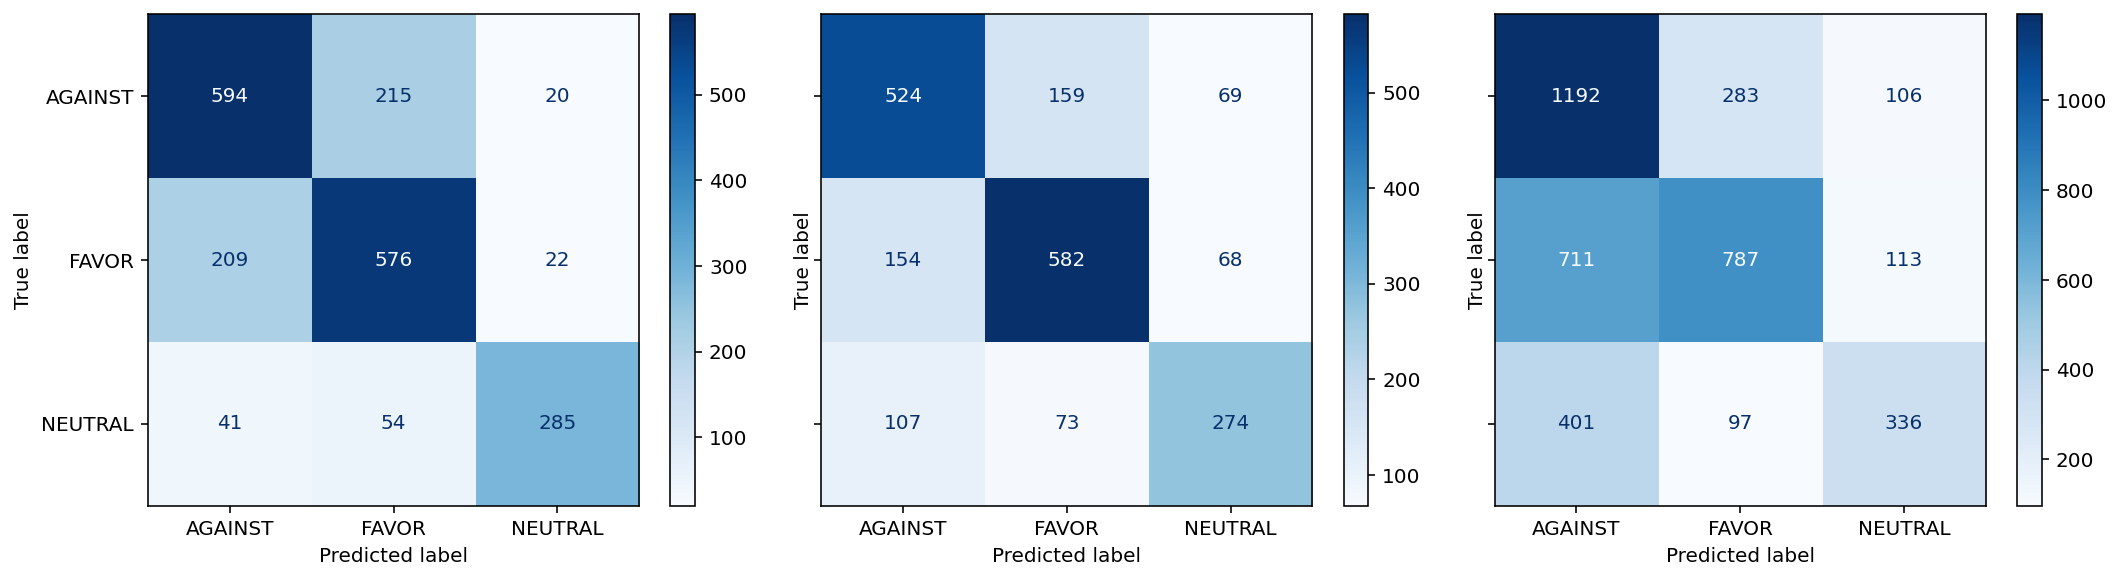

In [22]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

cf = confusion_matrix(spanish_test.LABEL, spanish_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, spanish_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[0], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(catalan_test.LABEL, catalan_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, catalan_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[1], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(combined_test.LABEL, combined_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, combined_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[2], xticks_rotation="horizontal", values_format="d")

fig.tight_layout()